In [ ]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

#### Download packages if in Google Colab

In [ ]:
colab_requirements = [
    "pip install tensorflow-gpu==2.0.0-beta0",
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",
    "pip install watson_developer_cloud"

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=abb74fead57f5875c8801835fe8c3959714afb41f53f968eb61efa402902b29f
Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce
Created wheel for watson-developer-cloud: filename=watson_developer_cloud-2.10.1-cp37-none-any.whl size=252815 sha256=6fc08844438c421fd48437a1b17f4fe774fa54512982f69761dd1cf688aeebb7
Stored in directory: /root/.cache/pip/wheels/ea/a7/19/fac0a408a586265eb374005308a7553d4494ab41b2fd88f5bc
Successfully built watson-developer-cloud


# **Алгоритм снижения шума по шагам**

In [ ]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### **Загрузка аудиодорожки**

In [ ]:
url = "https://www.signalogic.com/melp/EngSamples/Orig/ENG_M.wav"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
data = data

In [ ]:
IPython.display.Audio(data=data, rate=rate)

In [ ]:
print(f'Количество семплов: {len(data)}')

Количество семплов: 132007


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

No handles with labels found to put in legend.


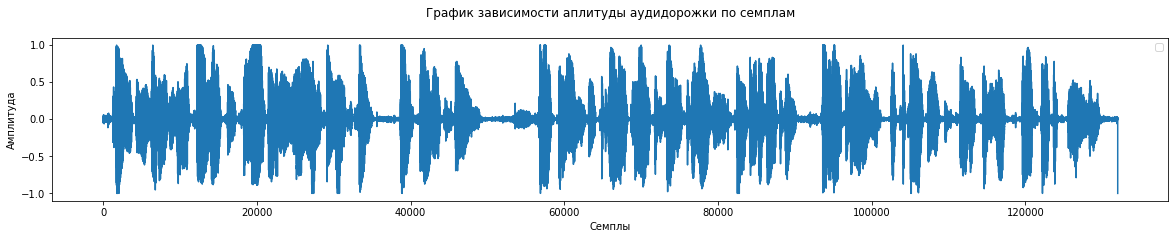

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)
ax.set_xlabel('Семплы')
ax.set_ylabel('Амплитуда')
ax.set_title('График зависимости аплитуды аудиодорожки по семплам\n')
ax.legend()
fig.show()

### **Добавление шума**

In [ ]:
noise_len = 16 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*50
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

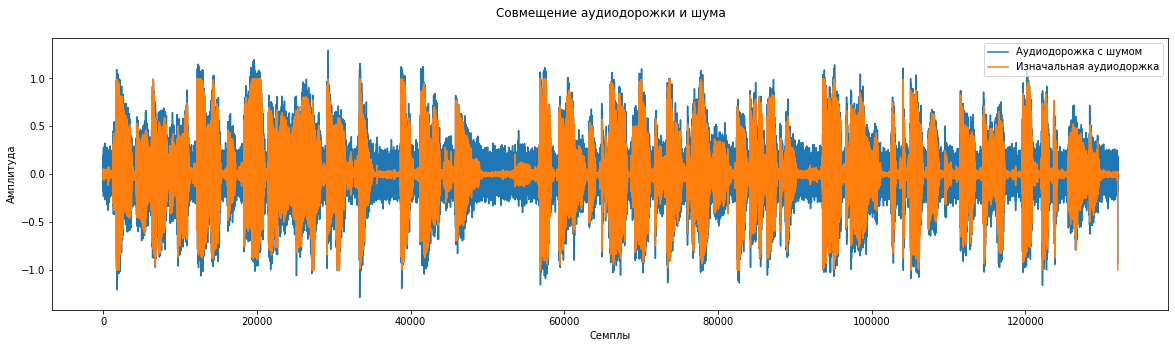

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(audio_clip_band_limited, label='Аудиодорожка с шумом')
ax.plot(data, label='Изначальная аудиодоржка')
ax.set_xlabel('Семплы')
ax.set_ylabel('Амплитуда')
ax.set_title('Совмещение аудиодорожки и шума\n')
ax.legend()
fig.show()


In [ ]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### **Удаление шума**

**Алгоритм снижения шума с использованием спектрального стробирования**
1. Вычисление быстрого преобразования Фурье (БПФ) по шумовому аудиоклипу
2. Вычисление статистики шума по БПФ (по частоте).
3. Вычисление порога на основе статистики шума (и желаемой чувствительности алгоритма).
4. Рассчитывание БПФ по сигналу
5. Опредление маски путем сравнения БПФ сигнала с пороговым значением.
6. Сглаживание маски фильтром по частоте и времени.
7. Добавление маски к БПФ сигнала и её дальнейшее инвертирование.

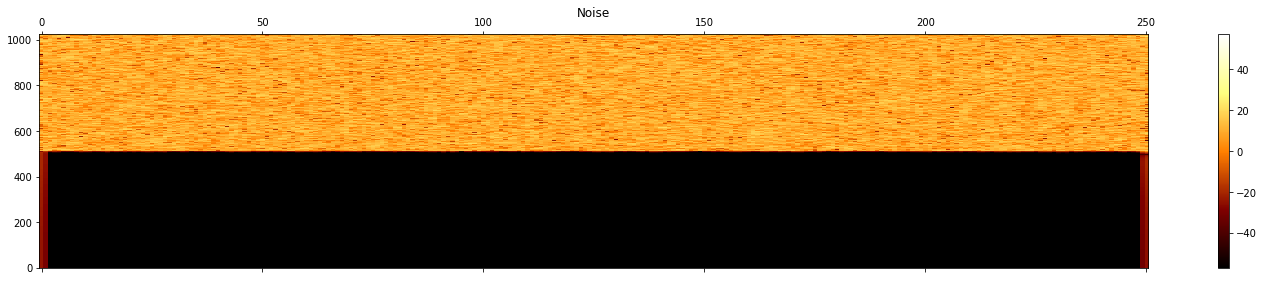

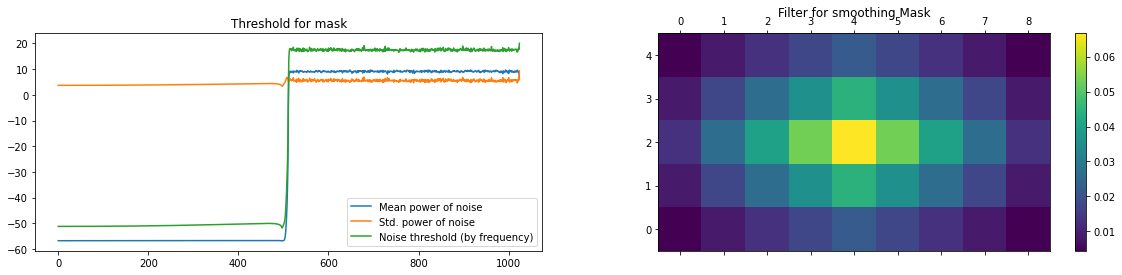

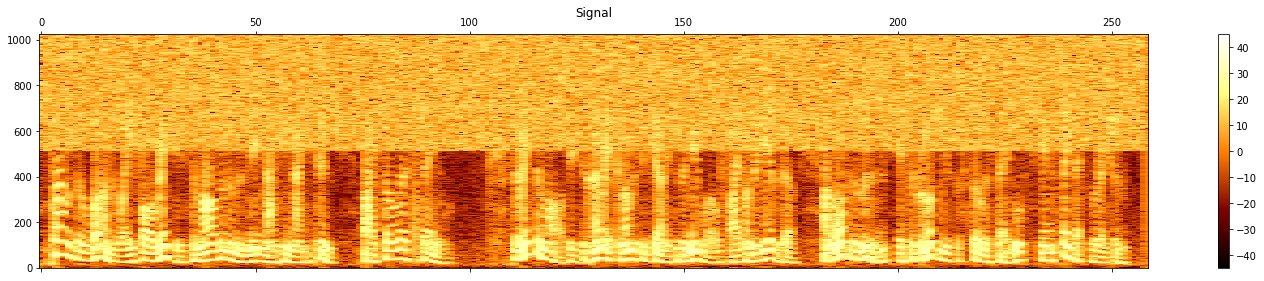

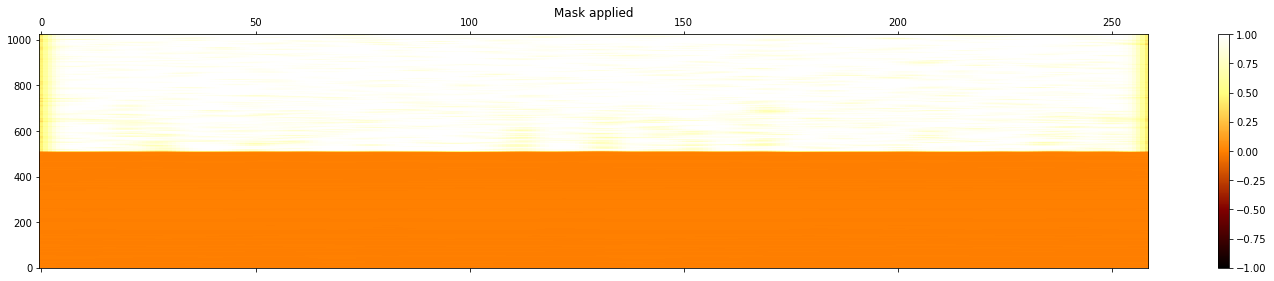

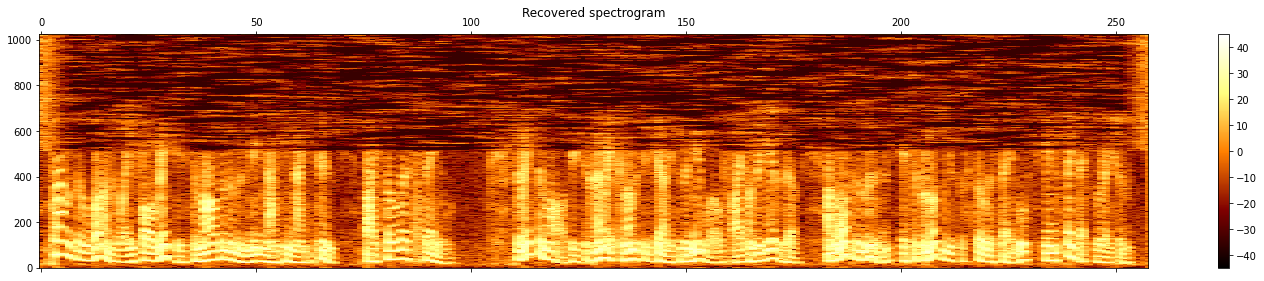

In [ ]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip, prop_decrease=1.0, verbose=True)



##### **Воспроизведение восстановленного аудио**

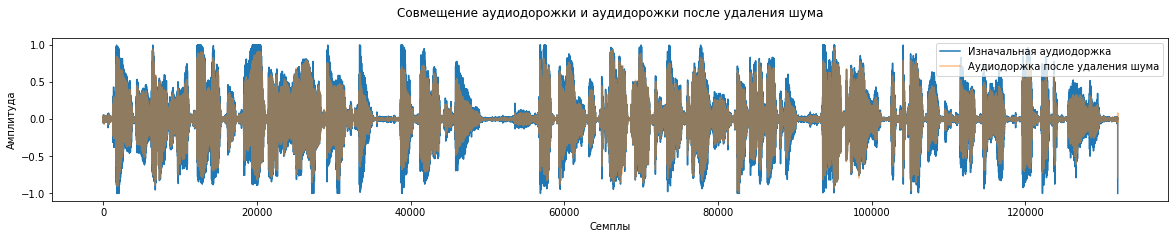

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data, label='Изначальная аудиодоржка')
ax.plot(noise_reduced, label='Аудиодоржка после удаления шума', alpha = 0.5)

ax.set_xlabel('Семплы')
ax.set_ylabel('Амплитуда')
ax.set_title('Совмещение аудиодорожки и аудидорожки после удаления шума\n')
ax.legend()
fig.show()

In [ ]:
IPython.display.Audio(data=noise_reduced, rate=rate)

## A more difficult example 

In [ ]:
# url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
url = "https://www.signalogic.com/melp/EngSamples/Orig/ENG_M.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

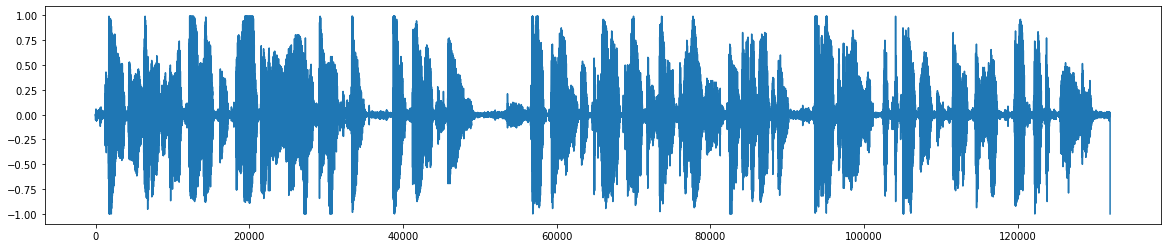

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [ ]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [ ]:
max(noise_data)

0.992156982421875

### add noise to data

In [ ]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

### plot noisy data

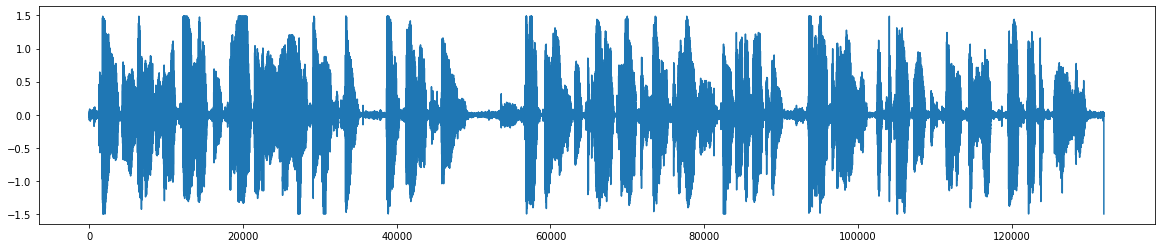

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)

IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

### reduce noise

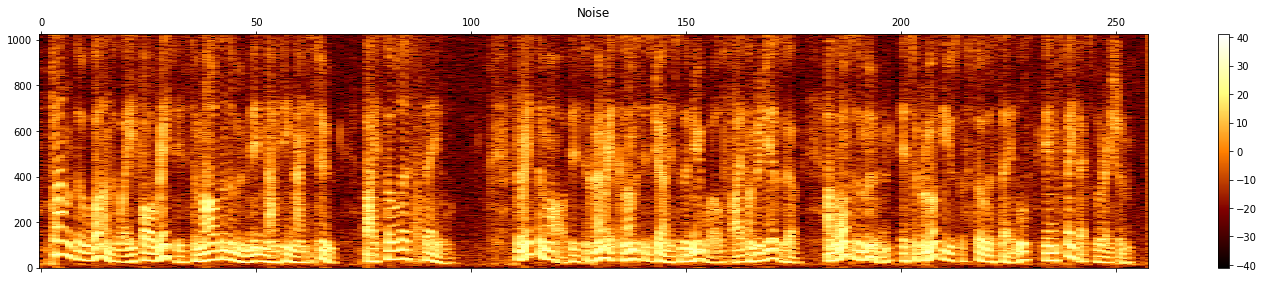

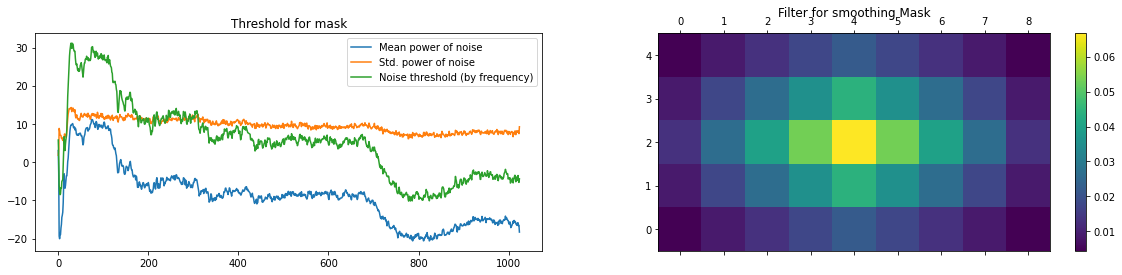

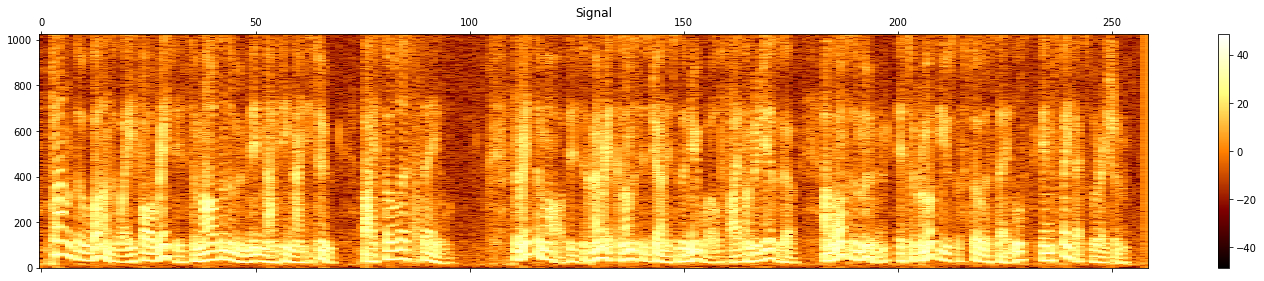

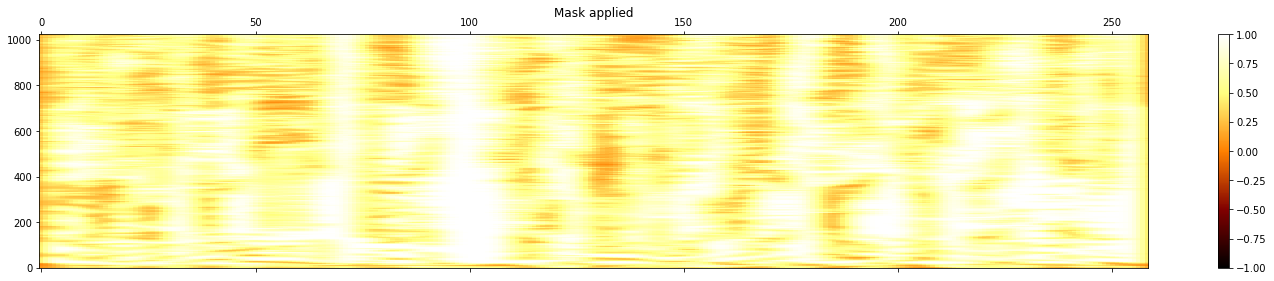

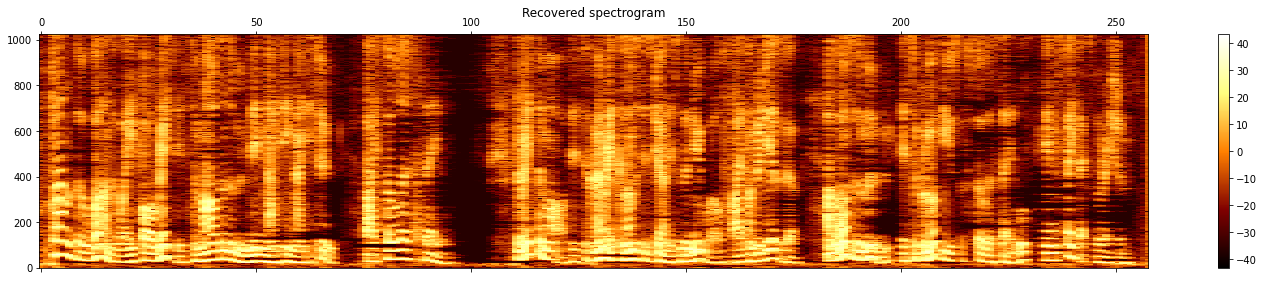

In [ ]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe, noise_clip=noise_clip, verbose=True)

##### playback recovered audio

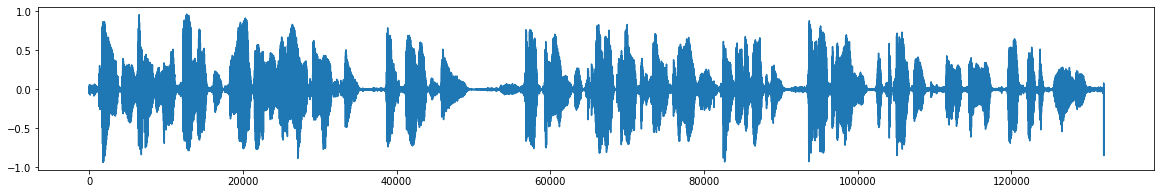

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced)

In [ ]:
IPython.display.Audio(data=noise_reduced, rate=rate)

## **Использование TensorFlow в качестве бэкэнда для шумоподавления**

In [ ]:
noise_reduced_tenserflow = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:162: UserWarning: Tensorflow is not installed, reverting to non-tensorflow backend
  "Tensorflow is not installed, reverting to non-tensorflow backend"


In [ ]:
len(data), len(audio_clip_band_limited)

(132007, 132007)

In [ ]:
# лишнее
# fig, ax = plt.subplots(figsize=(20,3))
# ax.plot(audio_clip_band_limited, label='Аудиодоржка c шумом')
# ax.plot(data, label='Изначальная аудиодоржка')
# # ax.plot(audio_clip_band_limited, alpha = 0.5, label='Аудиодоржка после удаления шума')
# ax.set_title('Совмещение аудиодорожки и шума\n')
# ax.legend()
# fig.show()

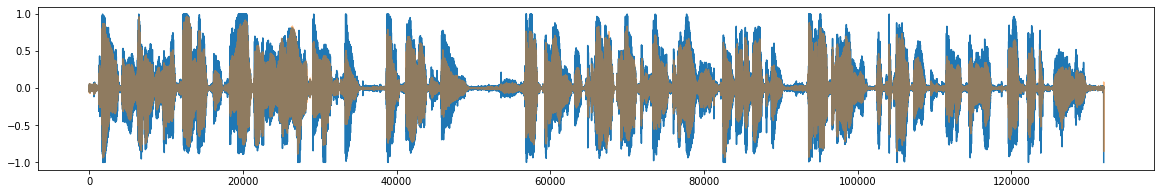

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)
ax.plot(noise_reduced_tenserflow , alpha = 0.5)

In [ ]:
IPython.display.Audio(data=noise_reduced_tenserflow, rate=rate)